In [183]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Packages

In [184]:
import cv2
import time
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import keras
from keras.activations import elu
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Layer
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import EfficientNetB5

# Setting parameters 

In [185]:
# 路徑
path2file = '/content/drive/MyDrive/FinalProject_王元蔚李鈺珊/'
path2testdata= '/content/drive/MyDrive/FinalProject_王元蔚李鈺珊/test_data_10/'
path2testlabel = path2testdata + 'test_labels_10.csv'
path2testimage = path2testdata + 'test_images_10/'

# 圖片大小
IMG_WIDTH_B3 = 300
IMG_HEIGHT_B3 = 300
IMG_WIDTH_B5 = 456
IMG_HEIGHT_B5 = 456
CHANNELS = 3

# Model
SEED=150
learning_rate=0.00005
BATCH_SIZE = 4

# Best Model
SAVED_MODEL_NAME_B3 = 'effnet_modelB3.h5'
SAVED_MODEL_NAME_B5 = 'effnet_modelB5.h5'

# Dataset

In [186]:
test_df=pd.read_csv(path2testlabel)
test_df['image'] = test_df['image'] + ".jpeg"
test_df.head()

,image,level
0,845_right.jpeg,0
1,851_left.jpeg,0
2,869_right.jpeg,1
3,978_left.jpeg,1
4,865_right.jpeg,2


# Preprocessing 

In [187]:
def crop_image_from_gray(img, tol=7):

    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [188]:
#B3
def preprocess_image_B3(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH_B3, IMG_HEIGHT_B3))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

In [189]:
#B5
def preprocess_image_B5(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH_B5, IMG_HEIGHT_B5))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

# Creating generater

In [190]:
test_df['predict_B3'] = np.zeros(test_df.shape[0]) 
test_df['predict_B5'] = np.zeros(test_df.shape[0]) 

In [191]:
test_datagen_B3 = ImageDataGenerator(preprocessing_function=preprocess_image_B3, 
                                   rescale=1 / 128.)
test_datagen_B5 = ImageDataGenerator(preprocessing_function=preprocess_image_B5, 
                                   rescale=1 / 128.) 
test_generator_B3 = test_datagen_B3.flow_from_dataframe(test_df, 
                                                  x_col='image', 
                                                  y_col='predict_B3',
                                                  directory = path2testimage,
                                                  target_size=(IMG_WIDTH_B3, IMG_HEIGHT_B3),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='other')
test_generator_B5 = test_datagen_B5.flow_from_dataframe(test_df, 
                                                  x_col='image', 
                                                  y_col='predict_B5',
                                                  directory = path2testimage,
                                                  target_size=(IMG_WIDTH_B5, IMG_HEIGHT_B5),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='other')

Found 10 validated image filenames.
Found 10 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

# Load pre-train model

In [192]:
effnet_B3 = EfficientNetB3(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_WIDTH_B3, IMG_HEIGHT_B3, CHANNELS))

In [193]:
effnet_B5 = EfficientNetB5(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_WIDTH_B5, IMG_HEIGHT_B5, CHANNELS))

# Building model

In [194]:
def build_model_B3():
    model = Sequential()
    model.add(effnet_B3)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation=elu))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['mse', 'acc'])
    print(model.summary())
    return model

model_B3 = build_model_B3()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d_16  (None, 1536)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_16 (Dropout)        (None, 1536)              0         
                                                                 
 dense_32 (Dense)            (None, 5)                 7685      
                                                                 
 dense_33 (Dense)            (None, 1)                 6         
                                                                 
Total params: 10,791,226
Trainable params: 10,703,923
Non-trainable params: 87,303
____________________________________

In [195]:
def build_model_B5():

    model = Sequential()
    model.add(effnet_B5)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation=elu))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['mse', 'acc'])
    print(model.summary())
    return model

model_B5 = build_model_B5()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 15, 15, 2048)     28513527  
                                                                 
 global_average_pooling2d_17  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_17 (Dropout)        (None, 2048)              0         
                                                                 
 dense_34 (Dense)            (None, 5)                 10245     
                                                                 
 dense_35 (Dense)            (None, 1)                 6         
                                                                 
Total params: 28,523,778
Trainable params: 28,351,035
Non-trainable params: 172,743
___________________________________

# Load weights

In [196]:
model_B3.load_weights(path2file + SAVED_MODEL_NAME_B3)

In [197]:
model_B5.load_weights(path2file + SAVED_MODEL_NAME_B5)

# Modeling

In [198]:
def get_preds_and_labels(model, generator):

    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)

    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [199]:
np.random.seed(SEED)

In [200]:
# B3
y_test, _ = get_preds_and_labels(model_B3, test_generator_B3)
y_test=y_test.round(0).astype("int")
test_df['predict_B3'] = y_test

In [201]:
# B5
y_test, _ = get_preds_and_labels(model_B5, test_generator_B5)
y_test=y_test.round(0).astype("int")
test_df['predict_B5']= y_test

In [202]:
display(test_df)

,image,level,predict_B3,predict_B5
0,845_right.jpeg,0,0,1
1,851_left.jpeg,0,2,0
2,869_right.jpeg,1,0,1
3,978_left.jpeg,1,2,0
4,865_right.jpeg,2,1,1
5,877_left.jpeg,2,2,0
6,932_right.jpeg,3,2,3
7,99_left.jpeg,3,0,0
8,936_right.jpeg,4,1,0
9,986_left.jpeg,4,0,0


# Results

In [203]:
odd= [i for i in range(10) if i % 2 == 1]
even= [i for i in range(10) if i % 2 != 1]
test_df_left=test_df.loc[odd]
test_df_left['predict_B5']= test_df_left['predict_B5']
test_df_left['predict_B3']= test_df_left['predict_B3']
test_df_left.reset_index(inplace=True, drop=True)

test_df_right=test_df.loc[even]
test_df_right['predict_B5']= test_df_right['predict_B5']
test_df_right['predict_B3']= test_df_right['predict_B3']
test_df_right.reset_index(inplace=True, drop=True)

## EfficientNetB3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version.


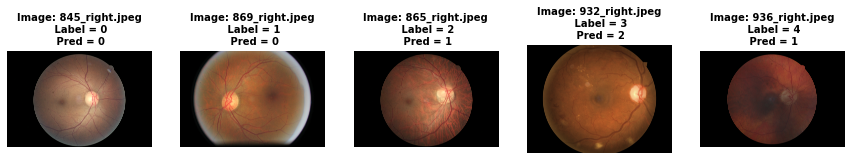

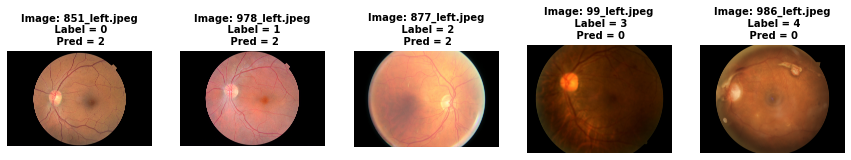

In [204]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = test_df_right[test_df_right['level'] == i ].sample(1)
    image_name = sample['image'].item()
    X = cv2.imread(f"{path2testimage}{image_name}")
    X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['level'].item()}\n Pred = {sample['predict_B3'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = test_df_left[test_df_left['level'] == i].sample(1)
    image_name = sample['image'].item()
    X = cv2.imread(f"{path2testimage}{image_name}")
    X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    sample['image'] = sample['image'].str.replace(r'.jpeg$', '')
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['level'].item()}\n Pred = {sample['predict_B3'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

## EfficientNetB5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version.


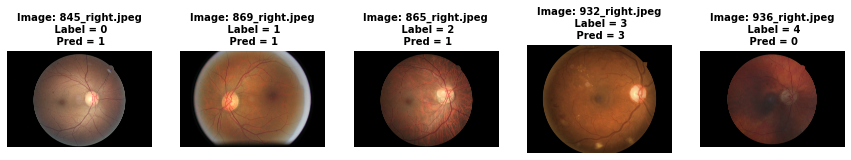

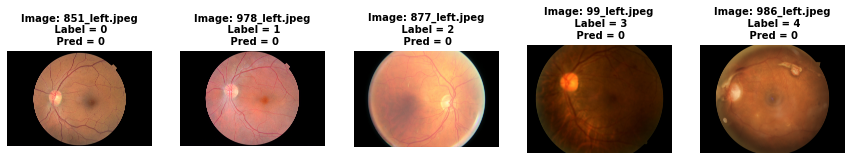

In [205]:
# EfficientNetB5
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = test_df_right[test_df_right['level'] == i ].sample(1)
    image_name = sample['image'].item()
    X = cv2.imread(f"{path2testimage}{image_name}")
    X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['level'].item()}\n Pred = {sample['predict_B5'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = test_df_left[test_df_left['level'] == i].sample(1)
    image_name = sample['image'].item()
    X = cv2.imread(f"{path2testimage}{image_name}")
    X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    sample['image'] = sample['image'].str.replace(r'.jpeg$', '')
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['level'].item()}\n Pred = {sample['predict_B5'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);